<a href="https://colab.research.google.com/github/taninao1122/machine_learning/blob/master/tf2_train_mobile_net_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基本設定と定義

In [1]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q tf-nightly

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras import models
print(tf.__version__)# 2.3.0

2.4.0-dev20200911


In [4]:
# used_extend = True
# show_extend = True

# label_lists = ["have_camera","no_camera"]
# n_categories = len(label_lists)
# drive_path = "./drive/My Drive/camera_checker"

# saved_dir_name = drive_path + "/model_extends_all"
# save_model_path = saved_dir_name + "/model" 

In [5]:
drive_path = "./drive/My Drive/camera_checker"
train_dir = os.path.join(drive_path + "/train")
val_dir =  os.path.join(drive_path + "/val")
test_dir = os.path.join(drive_path + "/test")

saved_dir_name = drive_path + "/model_test_1"
save_model_path = saved_dir_name + "/model" 

ディレクトリ作成用の関数の作成

In [43]:
def make_dir(path):
    if not os.path.exists(path):
            print('make ', path)
            os.mkdir(path)

# train事前準備

In [6]:
BATCH_SIZE = 32
IMG_SIZE =224

train_dataset = image_dataset_from_directory(train_dir,
                                             #shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE,IMG_SIZE))

validation_dataset = image_dataset_from_directory(val_dir,
                                                  #shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(IMG_SIZE,IMG_SIZE))

test_dataset = image_dataset_from_directory(test_dir,
                                            #shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMG_SIZE,IMG_SIZE))

Found 1002 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


# ラベルの表示

In [7]:
class_names = train_dataset.class_names
print(class_names)

['have_camera', 'no_camera']


In [8]:
n_categories = len(class_names)
print(n_categories)

2


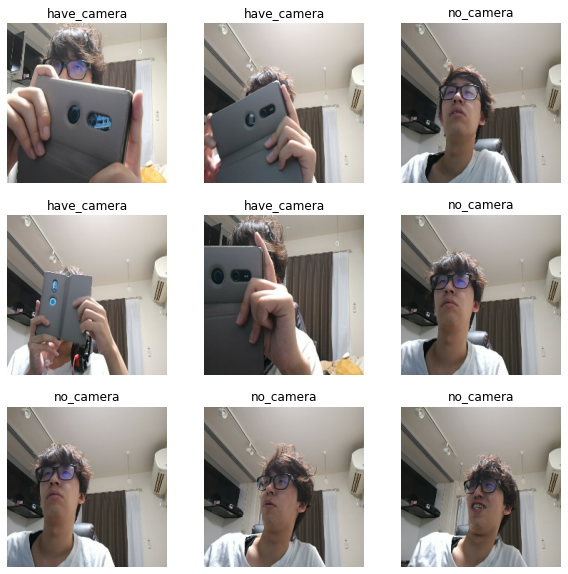

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# パフォーマンスのためのデータセット構成
- トレーニングステップの前処理とモデル実行をオーバーラップ
- 実行中はステップの一つ先を読み取る

- データが生成される時間とデータが消費される時間を分離するために使用

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
print(train_dataset)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


# データ拡張の指定
- 上記のtf.keras.layers.experimental.preprocessingでエラーが出た場合は
tf-nightlyでconflictが発生しているので以下のコマンドを実行
- !pip uninstall tf-nightly
- !pip install tensorflow --upgrade --force-reinstall

In [11]:
print(tf.__version__)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(.2, .2),
])
# 上記のtf.keras.layers.experimental.preprocessingでエラーが出た場合はtf-nightlyでconflictが発生しているので以下のコマンドを実行
# !pip uninstall tf-nightly
# !pip install tensorflow --upgrade --force-reinstall

2.4.0-dev20200911


<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


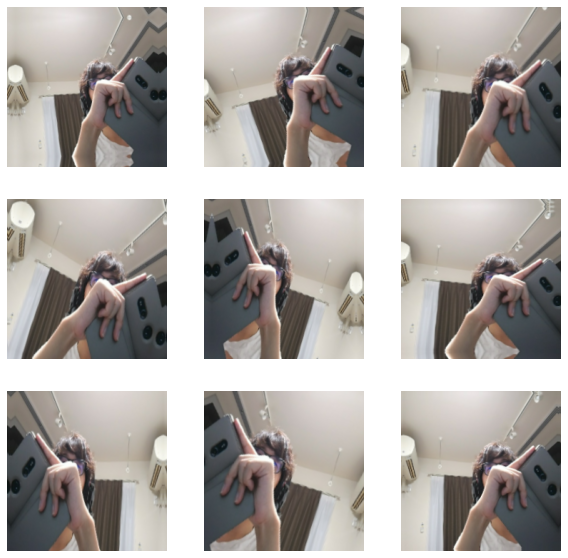

In [12]:
print(train_dataset.take(1))
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model定義

In [13]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

入力層の定義

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
print(IMG_SHAPE)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)


(224, 224, 3)


In [16]:
base_model = tf.keras.applications.MobileNetV2(input_tensor=x,
                                                input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [17]:
base_model.trainable = False
#base_model.summary()

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(n_categories)

In [19]:
x = base_model.output
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

## モデルの学習

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 特徴抽出

モデル保存用のディレクトリの作成

In [22]:
make_dir(saved_dir_name)
make_dir(save_model_path)


In [ ]:
model.summary()

1.2Kのトレーニング可能なパラメータがある。
これらはtf.Variableオブジェクトである重みとバイアスに分けられる

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 8s 821ms/step - loss: 0.6380 - accuracy: 0.6039


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.61


In [44]:
make_dir(save_model_path)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model_earlystopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_model_path , 'model_{epoch:03d}_val_accuracy_{val_accuracy:.4f}.h5'),
                            monitor='val_accuracy',
                            save_best_only=True,
                            save_weights_only=False,
                            mode='max',
                            verbose=1,
                            period=1)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[model_earlystopping,model_checkpoint])


学習したモデルの保存

In [28]:
model.save(save_model_path+'_last_model.h5')

学習結果の出力

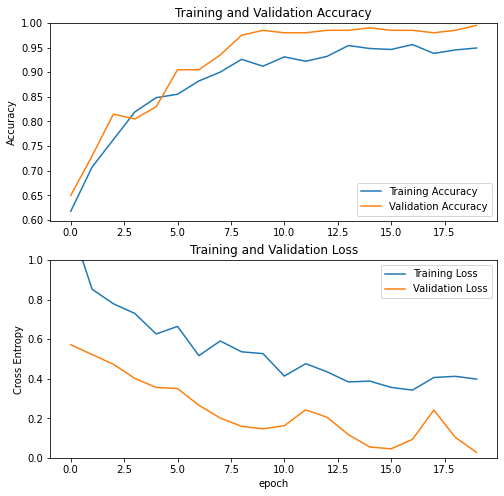

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**テスト実行結果**

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 6s 800ms/step - loss: 0.0855 - accuracy: 0.9950
Test accuracy : 0.9950000047683716


# ヒートマップの作成
[Visualizing Activation Heatmaps using TensorFlow \| by Areeb Gani \| Analytics Vidhya \| Medium](https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

In [31]:
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

def grad_cam(input_model,x,layer_name):
    X = np.expand_dims(x,axis=0)
    print(X.shape)
    preprocess_input = X.astype('float32') / 255.0
    grad_model = models.Model([model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocess_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:,0]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    rgb_cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image


In [ ]:
target_layer = 'Conv_1'
heatmap_path = os.path.join(saved_dir_name, 'heatmap_result')
make_dir(heatmap_path)

for label_name in class_names:
    one_label_path = os.path.join(test_dir,label_name)
    one_label_heatmap_path = os.path.join(heatmap_path,label_name)

    make_dir(one_label_heatmap_path)
    one_images_lists = os.listdir(one_label_path)
    print(class_names)
    for one_image in one_images_lists:
        heatmap_name = str(one_label_heatmap_path) +'/heatmap_' +str(one_image)
        one_image_path = os.path.join(one_label_path,one_image)
        x = img_to_array(load_img(one_image_path,target_size=(IMG_SIZE,IMG_SIZE) ))
        cam = grad_cam(model,x,target_layer)
        cv2.imwrite(heatmap_name, cam)
        

#TODO
- classification_report